[*********************100%***********************]  1 of 1 completed
C:\Users\zhiqu\AppData\Local\Temp\ipykernel_16876\2671398711.py:29: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(0, method='ffill').shift(1).fillna(0)


Annualized Sharpe Ratio: -0.67
Maximum Drawdown: -39.27%


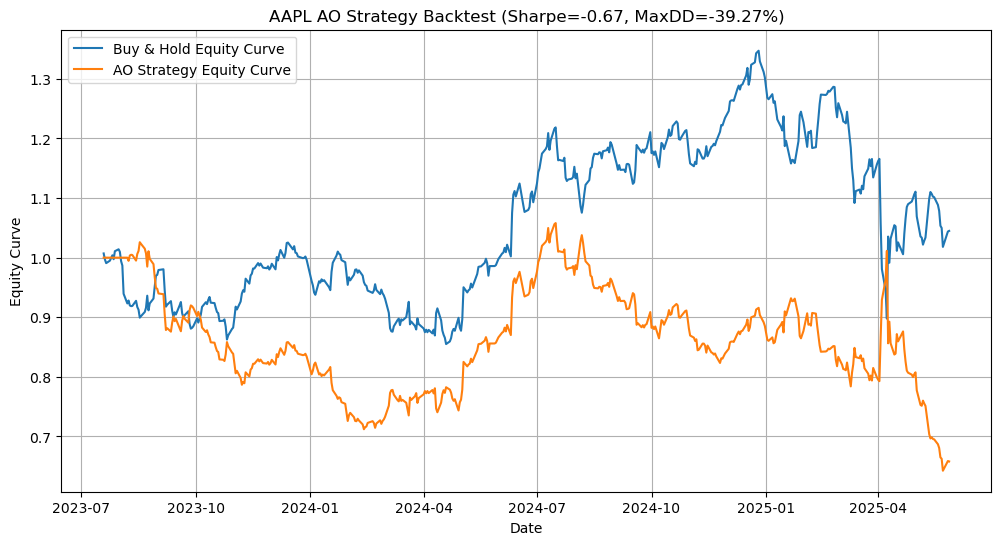

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Parameter settings
ticker   = "AAPL"    # symbol to backtest
period   = "2y"      # lookback period
interval = "1d"      # data frequency

# 2. Download data and clean
df = yf.download(ticker, period=period, interval=interval)
df.dropna(inplace=True)

# 3. Calculate median price and Awesome Oscillator (AO)
df['median_price'] = (df['High'] + df['Low']) / 2
df['ao_fast']      = df['median_price'].rolling(window=5).mean()   # 5-period SMA
df['ao_slow']      = df['median_price'].rolling(window=34).mean()  # 34-period SMA
df['AO']           = df['ao_fast'] - df['ao_slow']
df.dropna(inplace=True)

# 4. Generate signals: buy when AO crosses above zero, sell when it crosses below
df['AO_prev'] = df['AO'].shift(1)
df['signal']  = 0
df.loc[(df['AO'] > 0) & (df['AO_prev'] <= 0), 'signal'] =  1
df.loc[(df['AO'] < 0) & (df['AO_prev'] >= 0), 'signal'] = -1

# 5. Positions: carry forward last signal, apply next day
df['position'] = df['signal'].replace(0, method='ffill').shift(1).fillna(0)

# 6. Calculate daily returns for strategy and buy-and-hold
df['returns']   = df['Close'].pct_change()
df['strat_ret'] = df['position'] * df['returns']
df.dropna(inplace=True)

# 7. Build equity curves
df['equity_curve']      = (1 + df['strat_ret']).cumprod()
df['buy_hold_curve']    = (1 + df['returns']).cumprod()

# 8. Annualized Sharpe Ratio (assume risk-free rate ≈ 0)
sharpe_ratio = df['strat_ret'].mean() / df['strat_ret'].std() * np.sqrt(252)
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

# 9. Maximum Drawdown
df['cum_max']  = df['equity_curve'].cummax()
df['drawdown'] = df['equity_curve'] / df['cum_max'] - 1
max_dd = df['drawdown'].min()
print(f"Maximum Drawdown: {max_dd:.2%}")

# 10. Plot results: strategy vs. buy-and-hold
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['buy_hold_curve'], label='Buy & Hold Equity Curve')
plt.plot(df.index, df['equity_curve'],    label='AO Strategy Equity Curve')
plt.title(f"{ticker} AO Strategy Backtest (Sharpe={sharpe_ratio:.2f}, MaxDD={max_dd:.2%})")
plt.xlabel("Date")
plt.ylabel("Equity Curve")
plt.legend()
plt.grid(True)
plt.show()
